In [1]:
import numpy as np
import pandas as pd
import matplotlib
from IPython.display import Image as im
import matplotlib.pyplot as plt
from glob import glob
import random
import torch
from torchvision import transforms
import torch.nn as nn
from PIL import Image
import torch.tensor as tensor
import seaborn as sns; sns.set()
from torch.utils.data import DataLoader, Dataset
import cv2
import os

In [2]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
PATH = 'data'
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
train_df.head(10)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3


In [5]:
train_ids = sorted(os.listdir(os.path.join(PATH, 'train')))
masks_ids = sorted(os.listdir(os.path.join(PATH, 'masks')))
dataset_ids = list(zip(train_ids, masks_ids))

data_provider
karolinska    5456
radboud       5160
Name: image_id, dtype: int64


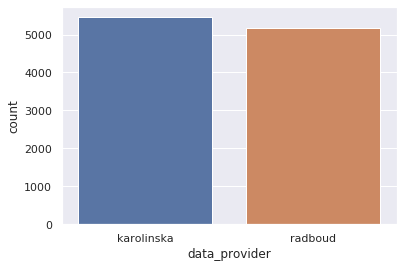

In [8]:
print(train_df.groupby('data_provider').count()['image_id'])
sns.countplot(x='data_provider', data=train_df)
plt.show()

In [13]:
train_df['gleason_score'].unique()

array(['0+0', '4+4', '3+3', '4+3', 'negative', '4+5', '3+4', '5+4', '5+5',
       '5+3', '3+5'], dtype=object)

gleason_score  data_provider
0+0            karolinska       1925
               radboud           967
3+3            karolinska       1814
               radboud           852
3+4            karolinska        667
               radboud           675
3+5            karolinska         13
               radboud            67
4+3            karolinska        318
               radboud           925
4+4            karolinska        466
               radboud           660
4+5            karolinska        208
               radboud           641
5+3            karolinska          2
               radboud            41
5+4            karolinska         27
               radboud           221
5+5            karolinska         16
               radboud           111
Name: image_id, dtype: int64


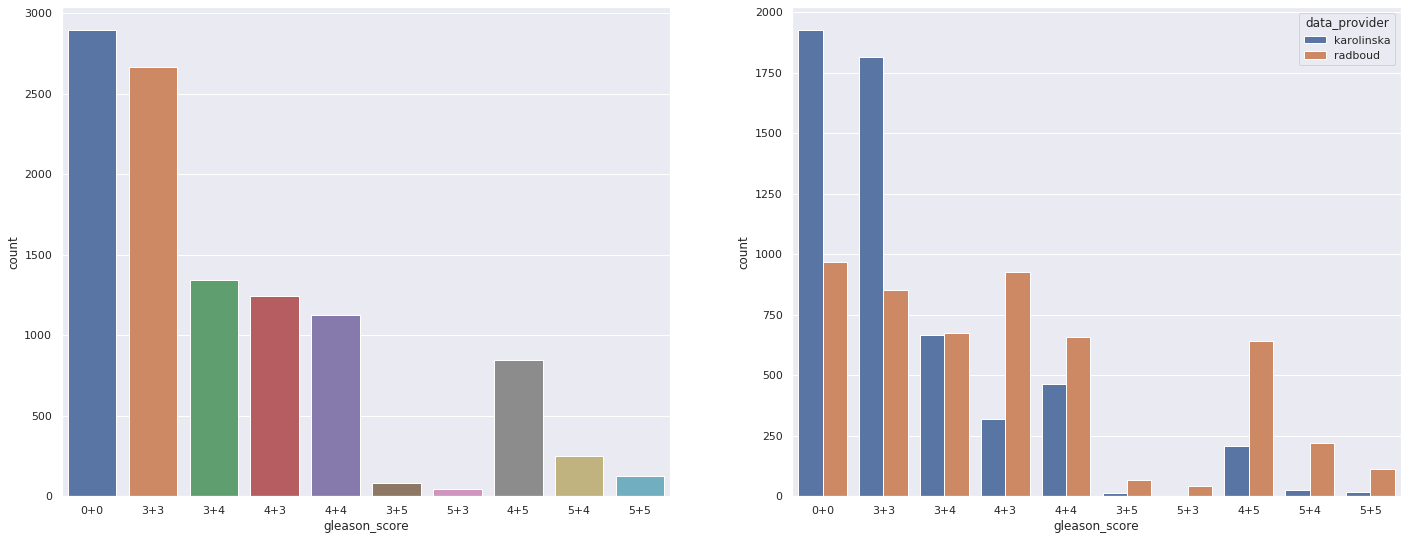

In [14]:
train_df.replace({'negative': '0+0'}, inplace=True)
order_id = ['0+0', '3+3', '3+4', '4+3', '4+4', 
            '3+5', '5+3', '4+5', '5+4', '5+5']
print(train_df.groupby(['gleason_score', 'data_provider']).count()['image_id'].loc[order_id])
_ = plt.figure(figsize=(24,9))
plt.subplot(121)
sns.countplot(x='gleason_score', data=train_df, order=order_id)
plt.subplot(122)
sns.countplot(x='gleason_score', data=train_df, hue='data_provider', order=order_id)
plt.show()

In [15]:
for score in order_id:
    maps_to = train_df[train_df['gleason_score'] == score]['isup_grade'].unique()
    print(f'gleason score "{score}" maps to "{maps_to}"')

gleason score "0+0" maps to "[0]"
gleason score "3+3" maps to "[1]"
gleason score "3+4" maps to "[2]"
gleason score "4+3" maps to "[3 2]"
gleason score "4+4" maps to "[4]"
gleason score "3+5" maps to "[4]"
gleason score "5+3" maps to "[4]"
gleason score "4+5" maps to "[5]"
gleason score "5+4" maps to "[5]"
gleason score "5+5" maps to "[5]"


In [16]:
train_df[(train_df['gleason_score'] == "4+3") & (train_df['isup_grade'] == 2)]

,image_id,data_provider,isup_grade,gleason_score
7273,b0a92a74cb53899311acc30b7405e101,karolinska,2,4+3


In [17]:
train_df.at[7273, 'isup_grade'] = 3

In [18]:
def plot(image, mask, dt): 
    _ = plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.imshow(image)
    title = f"""gleason_score:{dt['gleason_score']}
    data provider: {dt['data_provider']}
    id: {dt['image_id']}"""
    plt.title(title)
    plt.subplot(122)
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    plt.imshow(mask, cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.title("mask")
    plt.show()   

In [26]:
%%file src/dataset.py

from PIL import Image
import pandas as pd
import numpy as np
from glob import glob
import os
from torch.utils.data import DataLoader, Dataset
from cv2 import vconcat, hconcat

class PandaTilesDataset(Dataset):
    
    def __init__(self, path, train, masks, csv, preload=False):
        self.train_root = path
        self.df = pd.read_csv(os.path.join(self.train_root, csv)).set_index('image_id')
        self.pairs = list(zip(PandaTilesDataset.glob_imgs(os.path.join(self.train_root, train)), 
                              PandaTilesDataset.glob_imgs(os.path.join(self.train_root, masks))))
        self.preload = preload
        self.data = None
        if preload:
            self.data = [self._open_image(i) for i in range(0, len(self.pairs), 16)]
            
                         
    def __len__(self):
        return len(self.pairs) // 16
    
    
    def _open_image(self, index):
        img_id = self.pairs[index][0].split('/')[-1].split('_')[0] # re is better, maybe later
        h_concat_x = []
        h_concat_y = []
        for i in range(4): 
            hor_x = vconcat([PandaTilesDataset.array_img(self.pairs[index + i * 4 + j][0]) for j in range(4)])
            h_concat_x.append(hor_x)
            hor_y = vconcat([PandaTilesDataset.array_img(self.pairs[index + i * 4 + j][1]) for j in range(4)])
            h_concat_y.append(hor_y)
        
        image = hconcat(h_concat_x)
        mask  = hconcat(h_concat_y)
        desc = self.df.loc[img_id].to_dict()
        desc['image_id'] = img_id
        return image, mask, desc
        
        
    def __getitem__(self, idx):
        if self.preload:
            return self.data[idx]
        
        start_id = idx * 16
        image, mask, desc = self._open_image(start_id)                  
        return image, mask, desc 


    @classmethod
    def array_img(cls, img): 
        return np.array(Image.open(img))

    @classmethod
    def glob_imgs(cls, d):
        return sorted(glob(os.path.join(d, '*.png')))


class Radboud(PandaTilesDataset):

    def __init__(self, path, train, masks, csv, preload=False):
        super().__init__(path, train, masks, csv, preload)
        self.df = self.df[self.df['data_provider'] == 'radboud']
        self.images = list(self.df.index)
        self.pairs = [(x, y) for (x, y) in self.pairs if Radboud.img_id(x) in self.images]


    @classmethod
    def img_id(self, idx):
        img_id = idx.split('/')[-1].split('_')[0]
        return img_id

Overwriting src/dataset.py


In [27]:
from src.dataset import Radboud as RD, PandaTilesDataset as PD

In [28]:
general_dataset = PD(PATH, 'train', 'masks', 'train.csv', preload=False)

In [31]:
radboud_dataset = RD(PATH, 'train', 'masks', 'train.csv', preload=False)

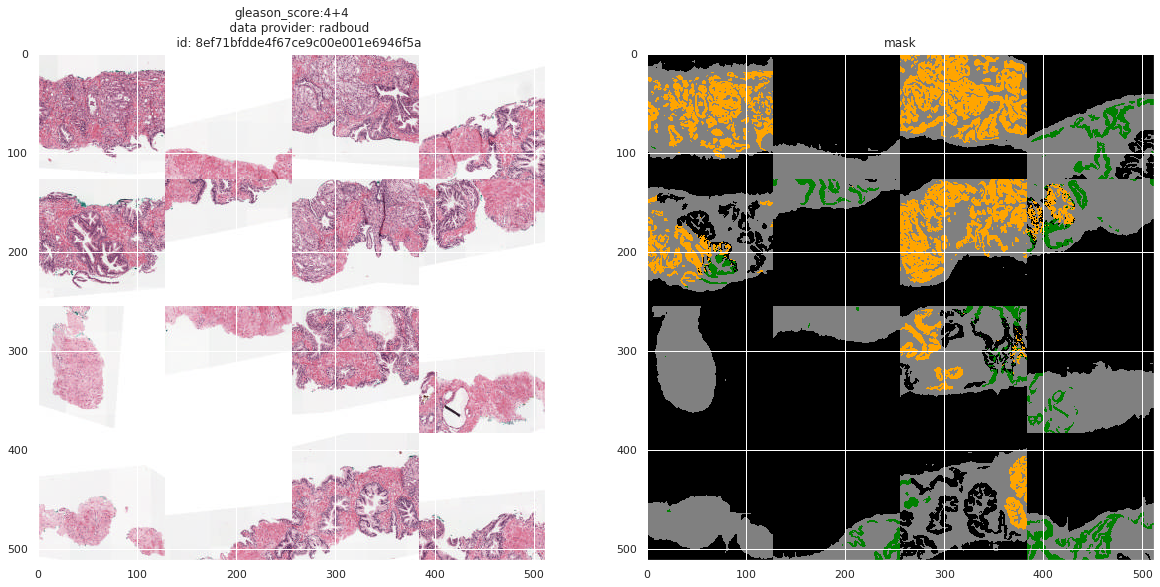

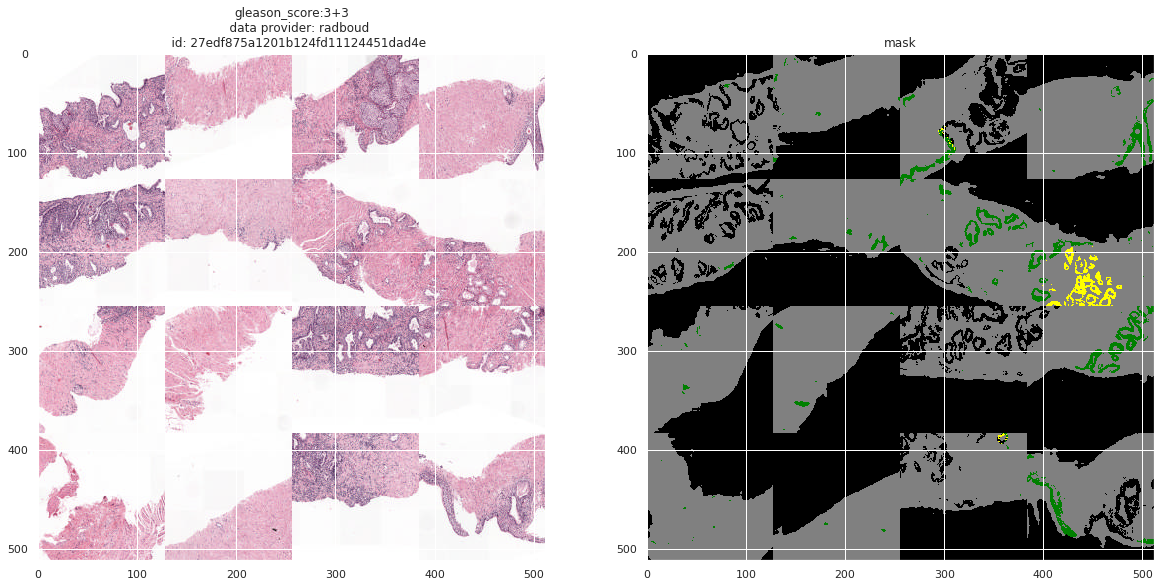

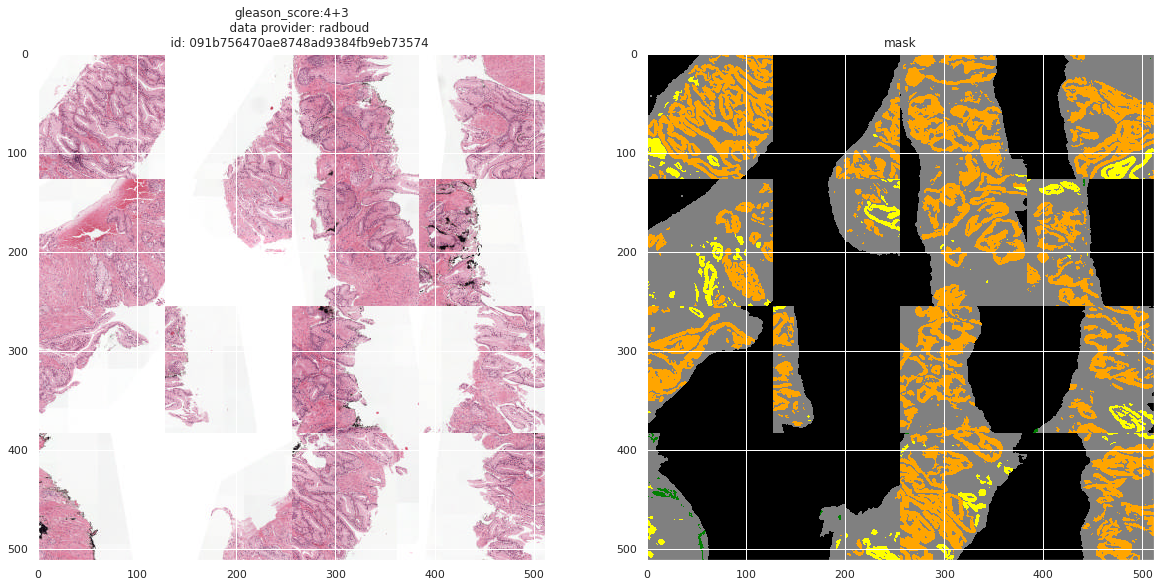

In [39]:
seed_all(23)

random_idx = np.random.choice(len(radboud_dataset), 3, replace=False)
for idx in random_idx:
    plot(*radboud_dataset[idx])